In [28]:
import io
import json
import pathlib
import tempfile
import shutil

import numpy as np
import tifffile
import zarr
from fsspec.implementations.reference import ReferenceFileSystem
from skimage import data as skdata
import fastplotlib as fpl
from tifffile import TiffFile

In [31]:
def dump_kerchunk_reference(tif_path: pathlib.Path) -> dict:
    with tifffile.TiffFile(str(tif_path)) as tif, io.StringIO() as f:
        store = tif.aszarr()
        store.write_fsspec(f, url=tif_path.resolve().as_uri())
        return json.loads(f.getvalue())

def create_combined_kerchunk_reference(tif_files: list[pathlib.Path], base_dir: pathlib.Path) -> dict:
    assert len(tif_files) > 1, "Need at least two TIFF files to combine."
    combined_refs: dict[str, str] = {}
    per_file_refs = []
    total_shape = None
    total_chunks = None
    zarr_meta = {}
    for tif_path in tif_files:
        inner_refs = dump_kerchunk_reference(tif_path)
        # inner_refs = dump_kerchunk_reference(tif_path, base_dir)
        zarr_meta = json.loads(inner_refs.pop(".zarray"))
        inner_refs.pop(".zattrs", None)

        shape = zarr_meta["shape"]
        chunks = zarr_meta["chunks"]

        if total_shape is None:
            total_shape = shape.copy()
            total_chunks = chunks
        else:
            assert shape[1:] == total_shape[1:], f"Shape mismatch in {tif_path}"
            assert chunks == total_chunks, f"Chunk mismatch in {tif_path}"
            total_shape[0] += shape[0]  # accumulate along axis 0

        per_file_refs.append((inner_refs, shape))

    combined_zarr_meta = {
        "shape": total_shape,
        "chunks": total_chunks,
        "dtype": zarr_meta["dtype"],
        "compressor": zarr_meta["compressor"],
        "filters": zarr_meta.get("filters", None),
        "order": zarr_meta["order"],
        "zarr_format": zarr_meta["zarr_format"],
        "fill_value": zarr_meta.get("fill_value", 0),
    }

    combined_refs[".zarray"] = json.dumps(combined_zarr_meta)
    combined_refs[".zattrs"] = json.dumps(
        {"_ARRAY_DIMENSIONS": ["T", "C", "Y", "X"][:len(total_shape)]}
    )

    axis0_offset = 0
    for inner_refs, shape in per_file_refs:
        chunksize0 = total_chunks[0]
        for key, val in inner_refs.items():
            idx = list(map(int, key.strip("/").split(".")))
            idx[0] += axis0_offset // chunksize0
            new_key = ".".join(map(str, idx))
            combined_refs[new_key] = val
        axis0_offset += shape[0]

    return combined_refs

def main_mbo():

    tmp_dir = pathlib.Path("./output").resolve()
    tmp_dir.mkdir(exist_ok=True)

    files = [x for x in pathlib.Path("/home/flynn/lbm_data/raw").glob("*.tif")]
    print("Generating combined kerchunk reference…")
    combined_refs = create_combined_kerchunk_reference(
        tif_files=files, base_dir=tmp_dir
    )

    combined_json_path = tmp_dir / "combined_refs.json"
    with open(combined_json_path, "w") as f:
        json.dump(combined_refs, f)
    print(f"Combined kerchunk reference written to {combined_json_path}")
    # store = zarr.storage.FsspecStore(ReferenceFileSystem(combined_refs, asynchronous=False))
    return combined_json_path

In [32]:
json_path = main_mbo()

with open(json_path) as f:
    refs = json.load(f)

fs = ReferenceFileSystem(refs)
store = zarr.storage.FsspecStore(fs)
z_arr = zarr.open(store)
iw = fpl.ImageWidget(z_arr)
iw.show()

Generating combined kerchunk reference…
Combined kerchunk reference written to /home/flynn/repos/work/mbo_utilities/demos/output/combined_refs.json


/tmp/ipykernel_3569922/1289375863.py:7: UserWarning: fs (<fsspec.implementations.reference.ReferenceFileSystem object at 0x768111501310>) was not created with `asynchronous=True`, this may lead to surprising behavior
  store = zarr.storage.FsspecStore(fs)


RFBOutputContext()

ReferenceNotReachable: Reference "0.0.0.0" failed to fetch target file:///home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00002.tif/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00002.tif

In [37]:
#!/usr/bin/env python3

import io
import json
import pathlib
import tempfile
import shutil

import numpy as np
import tifffile
import zarr
from fsspec.implementations.reference import ReferenceFileSystem
from skimage import data as skdata
import fastplotlib as fpl
from tifffile import TiffFile


def dump_kerchunk_reference(tif_path: pathlib.Path, base_dir: pathlib.Path) -> dict:
    """
    Create a kerchunk reference for a single TIFF file.

    Parameters
    ----------
    tif_path : pathlib.Path
        Path to the TIFF file on disk.
    base_dir : pathlib.Path
        Directory representing the “root” URI for the reference.

    Returns
    -------
    refs : dict
        A kerchunk reference dict (in JSON form) for this single TIFF.
    """
    with tifffile.TiffFile(str(tif_path.expanduser().resolve())) as tif:
        # Generate an “aszarr” (Kerchunk) store and write it into a StringIO buffer
        with io.StringIO() as f:
            store = tif.aszarr()
            store.write_fsspec(f, url=base_dir.as_uri())
            refs = json.loads(f.getvalue())
    return refs

def create_combined_kerchunk_reference(tif_files: list[pathlib.Path], base_dir: pathlib.Path) -> dict:
    assert len(tif_files) > 1, "Need at least two TIFF files to combine."

    combined_refs: dict[str, str] = {}
    per_file_refs = []
    total_shape = None
    total_chunks = None
    zarr_meta = {}
    for tif_path in tif_files:
        inner_refs = dump_kerchunk_reference(tif_path, base_dir)
        zarr_meta = json.loads(inner_refs.pop(".zarray"))
        inner_refs.pop(".zattrs", None)

        shape = zarr_meta["shape"]
        chunks = zarr_meta["chunks"]

        if total_shape is None:
            total_shape = shape.copy()
            total_chunks = chunks
        else:
            assert shape[1:] == total_shape[1:], f"Shape mismatch in {tif_path}"
            assert chunks == total_chunks, f"Chunk mismatch in {tif_path}"
            total_shape[0] += shape[0]  # accumulate along axis 0

        per_file_refs.append((inner_refs, shape))

    combined_zarr_meta = {
        "shape": total_shape,
        "chunks": total_chunks,
        "dtype": zarr_meta["dtype"],
        "compressor": zarr_meta["compressor"],
        "filters": zarr_meta.get("filters", None),
        "order": zarr_meta["order"],
        "zarr_format": zarr_meta["zarr_format"],
        "fill_value": zarr_meta.get("fill_value", 0),
    }

    combined_refs[".zarray"] = json.dumps(combined_zarr_meta)
    combined_refs[".zattrs"] = json.dumps(
        {"_ARRAY_DIMENSIONS": ["T", "C", "Y", "X"][:len(total_shape)]}
    )

    axis0_offset = 0
    for inner_refs, shape in per_file_refs:
        chunksize0 = total_chunks[0]
        for key, val in inner_refs.items():
            idx = list(map(int, key.strip("/").split(".")))
            idx[0] += axis0_offset // chunksize0
            new_key = ".".join(map(str, idx))
            combined_refs[new_key] = val
        axis0_offset += shape[0]

    return combined_refs

def main_mbo():

    tmp_dir = pathlib.Path("/home/flynn/lbm_data/raw")
    tmp_dir.mkdir(exist_ok=True)

    files = [x for x in pathlib.Path("/home/flynn/lbm_data/raw").glob("*.tif")]
    print("Generating combined kerchunk reference…")
    combined_refs = create_combined_kerchunk_reference(
        tif_files=files, base_dir=tmp_dir
    )

    combined_json_path = tmp_dir / "combined_refs.json"
    with open(combined_json_path, "w") as f:
        json.dump(combined_refs, f)
    print(f"Combined kerchunk reference written to {combined_json_path}")
    # store = zarr.storage.FsspecStore(ReferenceFileSystem(combined_refs, asynchronous=False))
    return combined_json_path

Generating combined kerchunk reference…
Combined kerchunk reference written to /home/flynn/lbm_data/raw/combined_refs.json


/tmp/ipykernel_3569922/3812148974.py:2: UserWarning: fs (<fsspec.implementations.reference.ReferenceFileSystem object at 0x7681112ff590>) was not created with `asynchronous=True`, this may lead to surprising behavior
  store = zarr.storage.FsspecStore(ReferenceFileSystem(str(json_path)))


RFBOutputContext()

/home/flynn/repos/work/mbo_utilities/.venv/lib/python3.12/site-packages/fastplotlib/graphics/features/_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
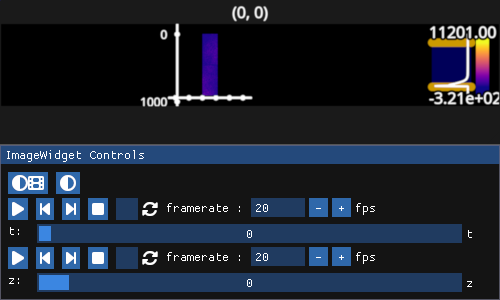

In [38]:
json_path = main_mbo()
store = zarr.storage.FsspecStore(ReferenceFileSystem(str(json_path)))
z_arr = zarr.open(store)
iw = fpl.ImageWidget(z_arr)
iw.show()

In [36]:
from pathlib import Path
files = [x for x in Path(r"/home/flynn/lbm_data/raw/out").glob("*.tif*")]
files

[]